In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torch
import torch.nn as nn
import tqdm

from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam
from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import ToTensor, Compose, RandomHorizontalFlip, RandomCrop, Normalize, Resize
from torchvision.models.vgg import vgg16

In [5]:
train = CIFAR10(root = "./", train = True, download = True, transform = ToTensor())
test = CIFAR10(root = "./", train = False, download = True, transform = ToTensor())

Files already downloaded and verified
Files already downloaded and verified


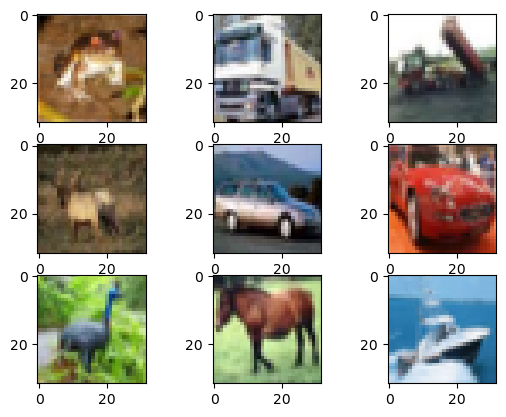

In [6]:
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train.data[i]);

### data augmentation

In [10]:
transforms = Compose([T.ToPILImage(),
                      RandomCrop((32, 32), padding = 4),
                      RandomHorizontalFlip(p = 0.5),])

train = CIFAR10(root = "./", train = True, download = True, transform = transforms)
test = CIFAR10(root = "./", train = False, download = True, transform = transforms)

Files already downloaded and verified
Files already downloaded and verified


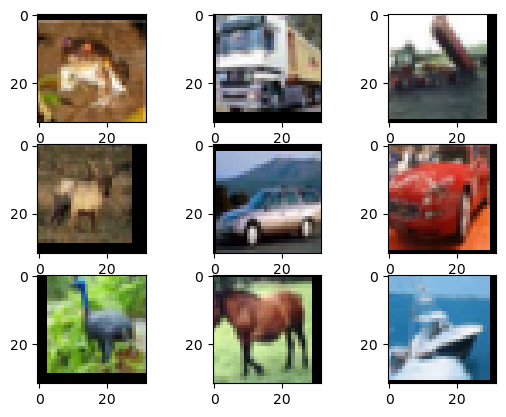

In [12]:
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(transforms(train.data[i]));

### Image Normalization

In [14]:
transforms = Compose([T.ToPILImage(),
                      RandomCrop((32, 32), padding = 4),
                      RandomHorizontalFlip(p = 0.5),
                      T.ToTensor(),
                      Normalize(mean = (0.4914, 0.4822, 0.4465), std = (0.247, 0.243, 0.261)), T.ToPILImage()])

train = CIFAR10(root = "./", train = True, download = True, transform = transforms)
test = CIFAR10(root = "./", train = False, download = True, transform = transforms)

Files already downloaded and verified
Files already downloaded and verified


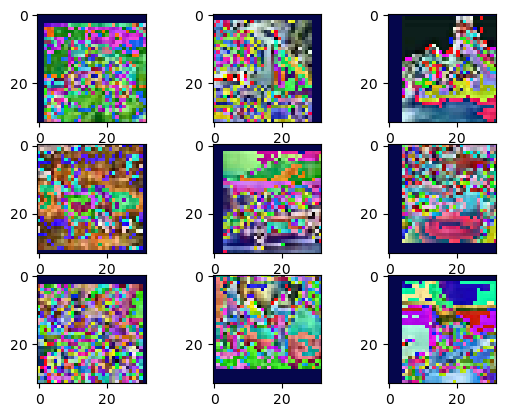

In [15]:
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(transforms(train.data[i]));

In [17]:
train = CIFAR10(root = "./", train = True, download = True, transform = ToTensor())

Files already downloaded and verified


In [19]:
# item[0] = imgae, item[1] = answer label

imgs = [item[0] for item in train]
imgs = torch.stack(imgs, dim = 0).numpy() # merge imgs into one

# mean per rgb
mean_r = imgs[:, 0, :, :].mean()
mean_g = imgs[:, 1, :, :].mean()
mean_b = imgs[:, 2, :, :].mean()
print(mean_r, mean_g, mean_b)

# std per rgb
std_r = imgs[:, 0,:,:].std()
std_g = imgs[:, 1,:,:].std()
std_b = imgs[:, 2,:,:].std()
print(std_r, std_g, std_b)

0.49139968 0.48215827 0.44653124
0.24703233 0.24348505 0.26158768


## Image classficiation by CNN

### Define VGG basicblock

In [34]:
# VGG 

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_dim):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, hidden_dim, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(hidden_dim, out_channels, kernel_size = 3, padding = 1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        return x

### Define VGG model

In [35]:
class CNN(nn.Module):
   def __init__(self, num_classes): 
       super(CNN, self).__init__()
       self.block1 = BasicBlock(in_channels = 3, out_channels = 32, hidden_dim = 16)
       self.block2 = BasicBlock(in_channels = 32, out_channels = 128, hidden_dim = 64)
       self.block3 = BasicBlock(in_channels = 128, out_channels = 256, hidden_dim = 128)

       self.fc1 = nn.Linear(in_features = 4096, out_features = 2048)
       self.fc2 = nn.Linear(in_features = 2048, out_features = 256)
       self.fc3 = nn.Linear(in_features = 256, out_features = num_classes)
       
       self.relu = nn.ReLU()

   def forward(self, x):
       x = self.block1(x)
       x = self.block2(x)
       x = self.block3(x)  # output shape: (-1, 256, 4, 4) 
       x = torch.flatten(x, start_dim = 1) 

       x = self.fc1(x)
       x = self.relu(x)
       x = self.fc2(x)
       x = self.relu(x)
       x = self.fc3(x)

       return x

In [36]:
transforms = Compose([RandomCrop((32, 32), padding=4),  
                      RandomHorizontalFlip(p=0.5),  
                      ToTensor(),  
                      Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))])

In [37]:
train = CIFAR10(root="./", train=True, download=True, transform = transforms)
test = CIFAR10(root="./", train=False, download=True, transform = transforms)

train_loader = DataLoader(train, batch_size=32, shuffle = True)
test_loader = DataLoader(test, batch_size=32, shuffle = False)

device = "cuda" if torch.cuda.is_available() else "cpu"

model = CNN(num_classes = 10)
model.to(device)

Files already downloaded and verified
Files already downloaded and verified


CNN(
  (block1): BasicBlock(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): BasicBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=4096, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=256,

### Train the model

In [38]:
lr = 1e-3
optim = Adam(model.parameters(), lr=lr)

for epoch in range(100):
   for data, label in train_loader:  
       optim.zero_grad() 

       preds = model(data.to(device))  

       loss = nn.CrossEntropyLoss()(preds, label.to(device)) 
       loss.backward() 
       optim.step() 

   if epoch == 0 or epoch % 10 == 9:  
       print(f"epoch{epoch+1} loss:{loss.item()}")

torch.save(model.state_dict(), "CIFAR.pth")

epoch1 loss:1.7924726009368896


KeyboardInterrupt: 

In [ ]:
model.load_state_dict(torch.load("CIFAR.pth", map_location=device))

num_corr = 0

with torch.no_grad():
   for data, label in test_loader:

       output = model(data.to(device))
       preds = output.data.max(1)[1]
       corr = preds.eq(label.to(device).data).sum().item()
       num_corr += corr

   print(f"Accuracy:{num_corr/len(test_data)}")

### VGG16 Model

In [ ]:
model = vgg16(pretrained=True) 
fc = nn.Sequential(nn.Linear(512 * 7 * 7, 4096),
                   nn.ReLU(),
                   nn.Dropout(),
                   nn.Linear(4096, 4096),
                   nn.ReLU(),
                   nn.Dropout(),
                   nn.Linear(4096, 10),)

model.classifier = fc
model.to(device)

In [ ]:
transforms = Compose([Resize(224),
                      RandomCrop((224, 224), padding=4),
                      RandomHorizontalFlip(p=0.5), ToTensor(),
                      Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))])

In [ ]:
train = CIFAR10(root="./", train = True, download = True, transform = transforms)
test = CIFAR10(root="./", train = False, download = True, transform = transforms)

train_loader = DataLoader(train, batch_size = 32, shuffle = True)
test_loader = DataLoader(test, batch_size = 32, shuffle = False)

In [ ]:
lr = 1e-4
optim = Adam(model.parameters(), lr=lr)

for epoch in range(5):
   iterator = tqdm.tqdm(train_loader) 
   for data, label in iterator:
       optim.zero_grad()

       preds = model(data.to(device))

       loss = nn.CrossEntropyLoss()(preds, label.to(device))
       loss.backward()
       optim.step()
     
       iterator.set_description(f"epoch:{epoch+1} loss:{loss.item()}")

torch.save(model.state_dict(), "CIFAR_pretrained.pth")

In [ ]:
model.load_state_dict(torch.load("CIFAR_pretrained.pth", map_location=device))

num_corr = 0

with torch.no_grad():
   for data, label in test_loader:

       output = model(data.to(device))
       preds = output.data.max(1)[1]
       corr = preds.eq(label.to(device).data).sum().item()
       num_corr += corr

   print(f"Accuracy:{num_corr/len(test_data)}")